## packages

In [110]:

import scanpy as sc
import numpy as np
import torch
import pandas as pd
import seaborn as sns
from torch_scatter import scatter
import networkx as nx
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## rawdata

In [111]:
adata = sc.read_h5ad('../data/20240527_4t1_hashtag_manual_annotation_tme_liver_breast_lymph.h5ad')

## normalize and generate KNN graph

In [112]:
print(adata.X.shape)
print(adata)

(57198, 23591)
AnnData object with n_obs × n_vars = 57198 × 23591
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'project_name_alias', 'percent.mt', 'sample_number', 'sample_treatment', 'nCount_SCT', 'nFeature_SCT', 'harmony_clusters', 'seurat_clusters', 'pca_clusters', 'cell_id', 'celltype_sctype_pre_annotaion', 'celltype_score_sctype_pre_annotaion', 'pre_annotaion_sctype_score', 'manual_celltype'
    var: 'name'
    obsm: 'X_harmony', 'X_pca', 'X_umap_harmony', 'X_umap_pca', 'X_umap_pca_dim30'


In [113]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
# sc.pp.scale(adata, max_value=10)

In [114]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'nCount_HTO',
       'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin',
       'HTO_classification', 'HTO_classification.global', 'hash.ID',
       'project_name_alias', 'percent.mt', 'sample_number', 'sample_treatment',
       'nCount_SCT', 'nFeature_SCT', 'harmony_clusters', 'seurat_clusters',
       'pca_clusters', 'cell_id', 'celltype_sctype_pre_annotaion',
       'celltype_score_sctype_pre_annotaion', 'pre_annotaion_sctype_score',
       'manual_celltype'],
      dtype='object')

In [115]:
used_label = "sample_treatment"

## Extract Features, Labels, and Adjacency Matrix

In [116]:
# Extract features, labels, and adjacency matrix
features = adata.obsm['X_pca']
adj_matrix = adata.obsp['connectivities']
labels = adata.obs[used_label].astype('category').cat.codes.values

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.long)
edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)

## Split Data into Training-development and Test Sets



In [117]:
# Split data into train and test sets
train_dev_data, test_data = train_test_split(adata, test_size=0.2, random_state=42)
train_data, dev_data = train_test_split(train_dev_data, test_size=0.2, random_state=42)

In [118]:
# Training data
X_train = torch.tensor(train_data.obsm['X_pca'], dtype=torch.float)
y_train = torch.tensor(train_data.obs[used_label].astype('category').cat.codes.values, dtype=torch.long)
train_edge_index = torch.tensor(train_data.obsp['connectivities'].nonzero(), dtype=torch.long)
train_data_gnn = Data(x=X_train, edge_index=train_edge_index, y=y_train)

# Development (validation) data
X_dev = torch.tensor(dev_data.obsm['X_pca'], dtype=torch.float)
y_dev = torch.tensor(dev_data.obs[used_label].astype('category').cat.codes.values, dtype=torch.long)
dev_edge_index = torch.tensor(dev_data.obsp['connectivities'].nonzero(), dtype=torch.long)
dev_data_gnn = Data(x=X_dev, edge_index=dev_edge_index, y=y_dev)

# Test data
X_test = torch.tensor(test_data.obsm['X_pca'], dtype=torch.float)
y_test = torch.tensor(test_data.obs[used_label].astype('category').cat.codes.values, dtype=torch.long)
test_edge_index = torch.tensor(test_data.obsp['connectivities'].nonzero(), dtype=torch.long)
test_data_gnn = Data(x=X_test, edge_index=test_edge_index, y=y_test)


## Define the GNN Model


In [119]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x


## train GNN model

In [120]:
model = GNN(in_channels=train_data_gnn.num_node_features, out_channels=2)  # Assuming 2 output classes
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    train_loss = train(model, optimizer, criterion, train_data_gnn)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}')


Epoch 1, Training Loss: 3.5083
Epoch 11, Training Loss: 0.4702
Epoch 21, Training Loss: 0.4950
Epoch 31, Training Loss: 0.3916
Epoch 41, Training Loss: 0.3471
Epoch 51, Training Loss: 0.3231
Epoch 61, Training Loss: 0.3160
Epoch 71, Training Loss: 0.3128
Epoch 81, Training Loss: 0.3096
Epoch 91, Training Loss: 0.3075


## Step 6: Evaluate the Model

In [121]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, predicted = out.max(dim=1)
        correct = predicted.eq(data.y).sum().item()
        accuracy = correct / len(data.y)
        return accuracy, out.detach().numpy()

train_accuracy, train_probs = evaluate(model, train_data_gnn)
dev_accuracy, dev_probs = evaluate(model, dev_data_gnn)
test_accuracy, test_probs = evaluate(model, test_data_gnn)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Development Accuracy: {dev_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Training Accuracy: 0.8837
Development Accuracy: 0.8823
Test Accuracy: 0.8789


In [122]:
test_accuracy

0.8789335664335665

## Plot confusion matrix

In [123]:
# conf_matrix = confusion_matrix(train_data.y[train_data.test_mask].numpy(), test_preds.numpy())
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_matrix, cmap='Blues')
# plt.colorbar()
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

## Plot ROC Curve

In [124]:
print(train_probs)
print(test_probs)

[[-2.621782   -0.0754493 ]
 [-3.7428448  -0.02397161]
 [-1.6412276  -0.21535161]
 ...
 [-4.136443   -0.0161086 ]
 [-1.9253047  -0.15762657]
 [-2.620914   -0.07551739]]
[[-0.9871818  -0.4662114 ]
 [-0.0561032  -2.9084833 ]
 [-0.04651654 -3.0911167 ]
 ...
 [-0.7153452  -0.67143136]
 [-3.0272672  -0.04966076]
 [-2.8079357  -0.06222596]]


In [125]:
test_data_gnn.y.numpy()

array([0, 0, 0, ..., 1, 1, 1])

In [126]:
y_true = train_data_gnn.y.numpy()
print(y_true)

[1 1 1 ... 0 0 0]


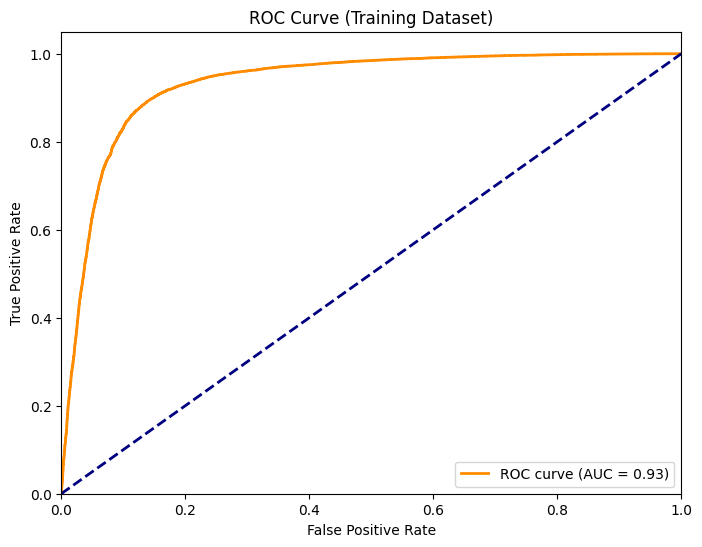

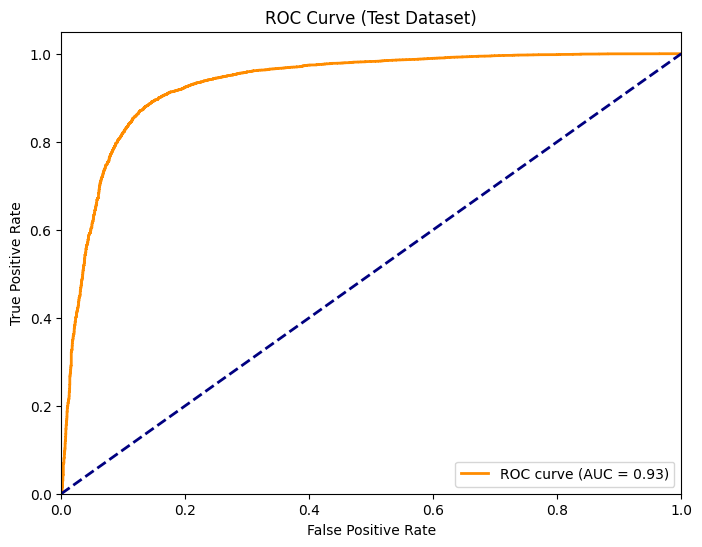

In [127]:
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])  # Assuming 2 output classes
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(train_data_gnn.y.numpy(), train_probs, 
               title='ROC Curve (Training Dataset)')
plot_roc_curve(test_data_gnn.y.numpy(), test_probs, 
               title='ROC Curve (Test Dataset)')


## barplot accuracy

Training Accuracy: 0.8837
Development Accuracy: 0.8823
Test Accuracy: 0.8789


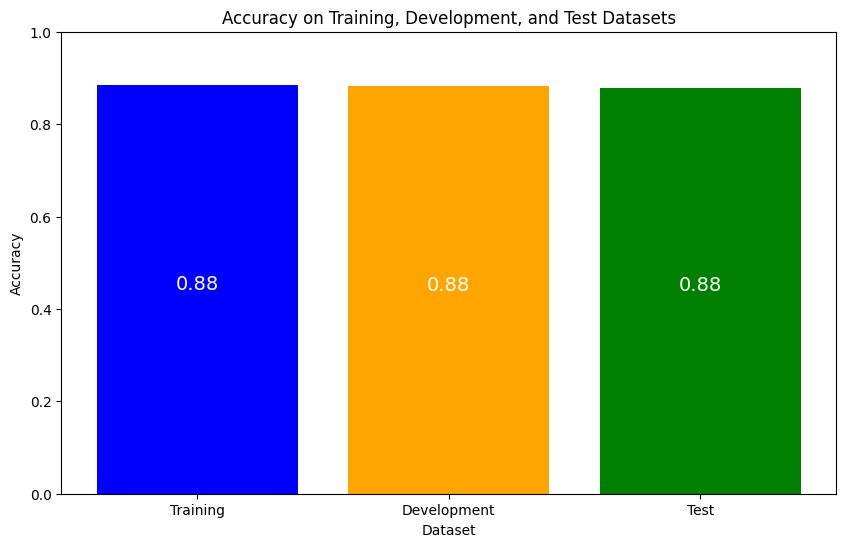

In [128]:
# Define the evaluate function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, predicted = torch.max(out, 1)
        correct = (predicted == data.y).sum().item()
        accuracy = correct / data.y.size(0)
        return accuracy

# Calculate accuracy for each dataset
train_accuracy = evaluate(model, train_data_gnn)
dev_accuracy = evaluate(model, dev_data_gnn)
test_accuracy = evaluate(model, test_data_gnn)

# Print the accuracies
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Development Accuracy: {dev_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Prepare data for bar plot
accuracies = [train_accuracy, dev_accuracy, test_accuracy]
datasets = ['Training', 'Development', 'Test']

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(datasets, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy on Training, Development, and Test Datasets')
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] / 2, f'{accuracies[i]:.2f}', ha='center', color='white', fontsize=14)
plt.show()


## plot trained embedding

In [129]:
# To get the embeddings
def get_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model.get_embeddings(data)
    return embeddings

# Extract embeddings from the trained model
train_embeddings = get_embeddings(model, train_data_gnn).numpy()
train_labels = train_data_gnn.y.numpy()

## t-SNE

/tmp/ipykernel_492773/636727864.py:7: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(x=train_embeddings_2d[:, 0],


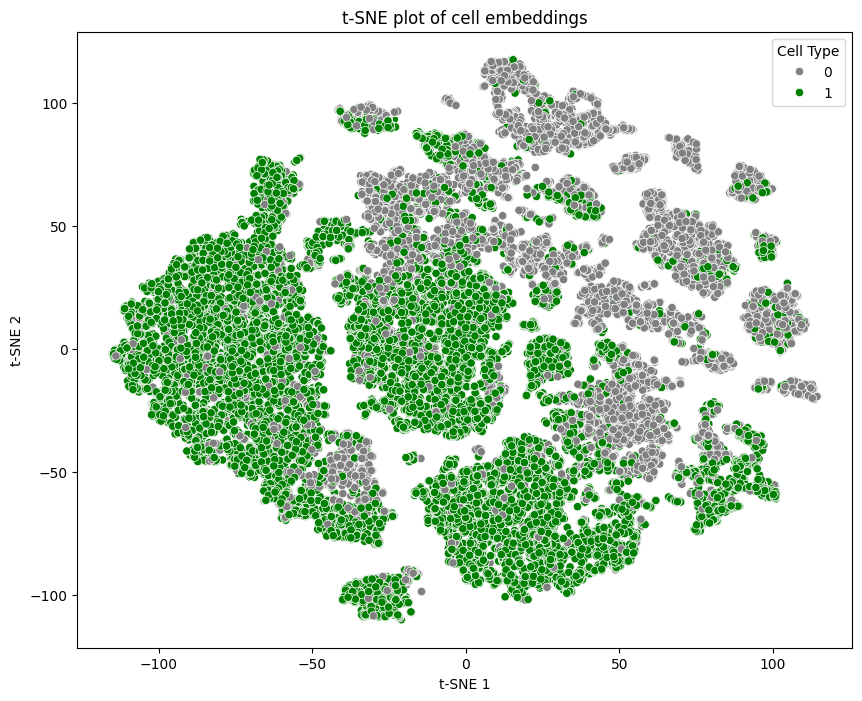

In [130]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)
# Plotting
plt.figure(figsize=(10, 8))
colors = np.array(['grey', 'green'])
sns.scatterplot(x=train_embeddings_2d[:, 0], 
                y=train_embeddings_2d[:, 1], hue=train_labels, 
                palette=colors)
plt.title('t-SNE plot of cell embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cell Type')
plt.show()

## UMAP

In [131]:
# Apply UMAP
import umap.umap_ as umap
umap_model = umap.UMAP(n_components=2, random_state=42)
train_embeddings_umap = umap_model.fit_transform(train_embeddings)

/data/cjd/packages/miniforge3/envs/dl/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_492773/2630722916.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(x=train_embeddings_umap[:, 0],


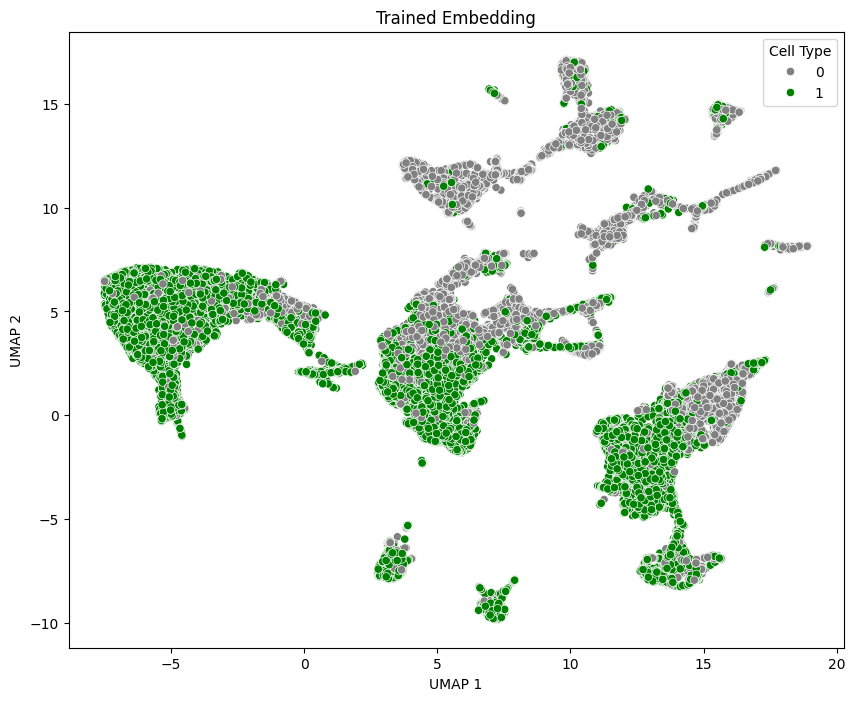

In [132]:
plt.figure(figsize=(10, 8))
colors = np.array(['grey', 'green'])
# point_colors = colors[labels]
sns.scatterplot(x=train_embeddings_umap[:, 0], 
                y=train_embeddings_umap[:, 1], 
                hue=train_labels, palette=colors)

plt.title('Trained Embedding')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cell Type')
plt.show()